# Food Delivery Time Prediction

## Objective
 The goal is to predict whether a food delivery will be "Fast" or "Delayed" based on features like customer location, restaurant location, weather, traffic conditions, and more. This dataset can be used to explore clustering and neural network models for predictive analytics.

## Phase 1 - Data Preprocessing and Feature Engineering
1. Data Import and Cleaning:
    1. Load the dataset (Food_Delivery_Time_Prediction.csv).
    2. Handle missing values through imputation or removal.
    3. Encode categorical variables (e.g., weather, traffic conditions) using One-Hot Encoding or Label Encoding.
    4. Normalize numerical features (e.g., Distance, Delivery Time).

2. Feature Engineering:
    1. Calculate geographical distance using the Haversine formula if not provided.
    2. Derive time-related features such as "rush hour" or "non-rush hour".


### Data Importing and cleaning

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
df.dropna(subset=['Delivery_Time'], inplace=True)
imputer = SimpleImputer(strategy='median')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = imputer.fit_transform(df[num_cols])

df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4.0,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8.0,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9.0,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2.0,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6.0,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


### Encode Categorical Variables

In [69]:
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Vehicle_Type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Normalize Numerical Features

In [70]:
scaler = MinMaxScaler()
numerical_features = ['Distance', 'Delivery_Time']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Order_Priority_Low,Order_Priority_Medium,Vehicle_Type_Bike,Vehicle_Type_Car
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",0.043068,4.0,Afternoon,4.1,3.0,0.105228,1321.10,81.54,True,False,False,False,True,False,True,False,True
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0.853158,8.0,Night,4.5,4.2,0.453658,152.21,29.02,False,False,False,False,True,True,False,False,True
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",0.263741,9.0,Night,3.3,3.4,0.317886,1644.38,64.17,False,True,False,False,True,False,False,True,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.544299,2.0,Evening,3.2,3.7,0.923018,541.25,79.23,False,False,False,True,False,False,True,True,False
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",0.254307,6.0,Night,3.5,2.8,0.164209,619.81,2.34,True,False,False,False,False,True,False,True,False


### Feature Engineering - Geographical Distance

In [71]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in km
    return c * r

# Extract lat/lon and compute Haversine distance
def extract_coords(coord_str):
    lat, lon = coord_str.strip('()').split(', ')
    return float(lat), float(lon)

df['geo_distance'] = df.apply(
    lambda row: haversine(*extract_coords(row['Customer_Location']), *extract_coords(row['Restaurant_Location'])),
    axis=1
)


df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Order_Priority_Low,Order_Priority_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,geo_distance
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",0.043068,4.0,Afternoon,4.1,3.0,0.105228,1321.10,81.54,True,False,False,False,True,False,True,False,True,775.651198
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0.853158,8.0,Night,4.5,4.2,0.453658,152.21,29.02,False,False,False,False,True,True,False,False,True,1042.385597
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",0.263741,9.0,Night,3.3,3.4,0.317886,1644.38,64.17,False,True,False,False,True,False,False,True,False,476.220706
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.544299,2.0,Evening,3.2,3.7,0.923018,541.25,79.23,False,False,False,True,False,False,True,True,False,389.912629
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",0.254307,6.0,Night,3.5,2.8,0.164209,619.81,2.34,True,False,False,False,False,True,False,True,False,806.505886


### Time Feature: Rush Hour Tagging
Assuming these rules:
1. Rush hour: Morning (7–10am), Evening (5–8pm)
2. Non-rush: Rest

In [72]:
def classify_rush_hour(order_time):
    rush_times = ['Morning', 'Evening']
    return 1 if order_time in rush_times else 0

df['is_rush_hour'] = df['Order_Time'].apply(classify_rush_hour)
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Order_Priority_Low,Order_Priority_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,geo_distance,is_rush_hour
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",0.043068,4.0,Afternoon,4.1,3.0,0.105228,1321.10,81.54,True,False,False,False,True,False,True,False,True,775.651198,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0.853158,8.0,Night,4.5,4.2,0.453658,152.21,29.02,False,False,False,False,True,True,False,False,True,1042.385597,0
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",0.263741,9.0,Night,3.3,3.4,0.317886,1644.38,64.17,False,True,False,False,True,False,False,True,False,476.220706,0
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.544299,2.0,Evening,3.2,3.7,0.923018,541.25,79.23,False,False,False,True,False,False,True,True,False,389.912629,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",0.254307,6.0,Night,3.5,2.8,0.164209,619.81,2.34,True,False,False,False,False,True,False,True,False,806.505886,0


## Phase 2 - Clustering using K-Means and Hierarchical Clustering
### K-Means Clustering
1. Objective Use K-Means Clustering to group similar delivery times and characteristics based on features such as customer and restaurant locations, weather, traffic conditions, and more.
2. Implementation
    * Apply the K-Means algorithm to segment data into clusters based on delivery time patterns.
    * Use Elbow Method to determine the optimal number of clusters.
3. Evaluation:
    * Visualize clusters using 2D or 3D scatter plots.
    * Analyze how delivery times are influenced by different clusters.

📌 Implementation

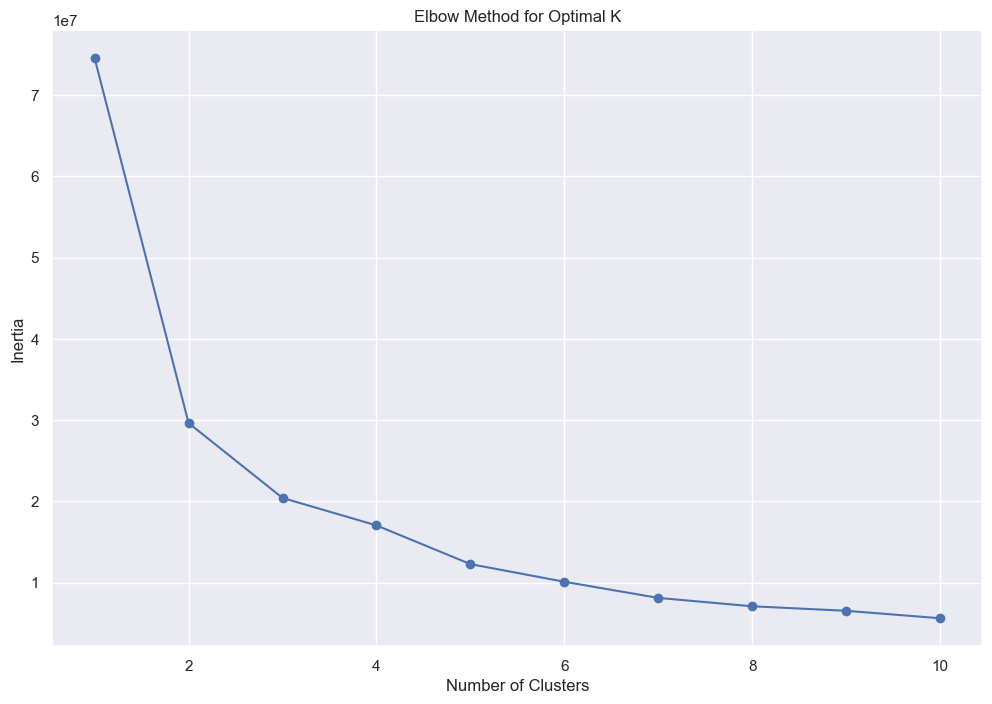

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

features = df.drop(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Order_Time'], axis=1)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=25)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (12,8))
plt.plot(k_range, inertia, marker = 'o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Final Clustering and Visualization

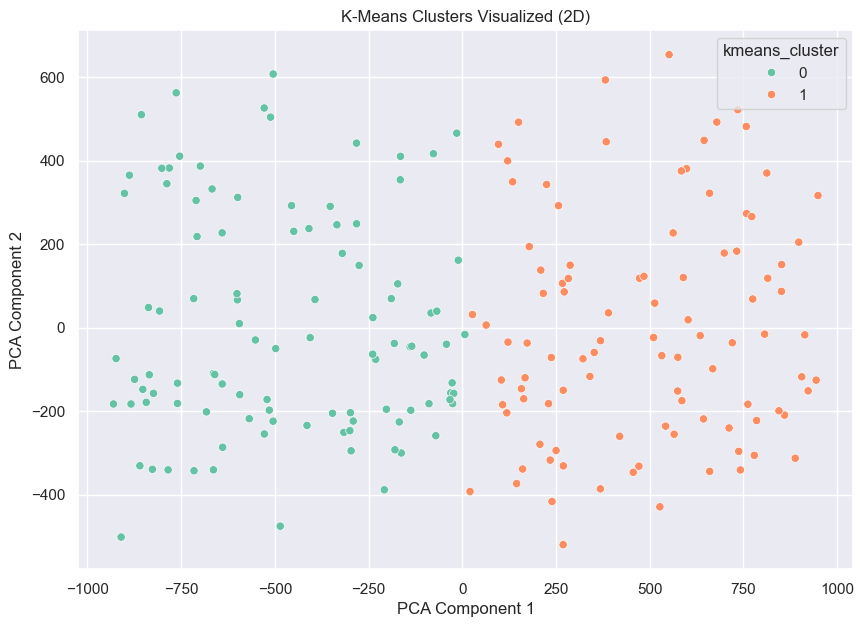

In [74]:
kmeans = KMeans(n_clusters=2, random_state=25)
df['kmeans_cluster'] = kmeans.fit_predict(features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=df['kmeans_cluster'], palette='Set2')
plt.title('K-Means Clusters Visualized (2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Hierarchical Clustering
1. Objective Perform hierarchical clustering to understand how the features like traffic, weather, and location group together in a hierarchical structure.
2. Implementation
    * Apply Agglomerative Clustering to the dataset.
    * Use dendrograms to visualize the clusters and decide on the optimal number of clusters.
3. Evaluation
    * Visualize the hierarchy using a dendrogram.
    * Compare cluster analysis with K-Means results to find patterns.


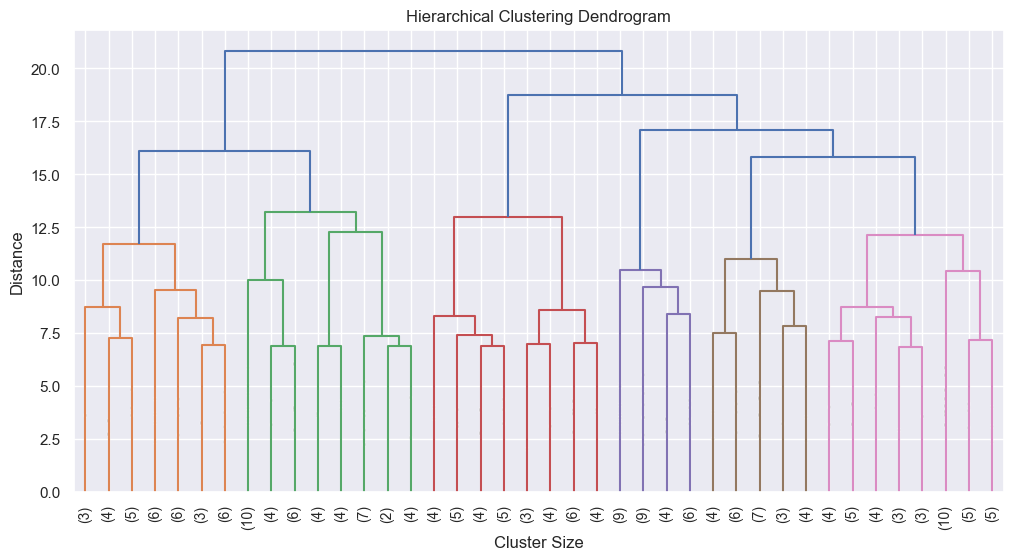

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# Scale features
scaled_features = StandardScaler().fit_transform(features)

# Apply hierarchical clustering
linked = linkage(scaled_features, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=40, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


### Cluster Analysis

In [23]:
print(df.groupby('kmeans_cluster')['Delivery_Time'].mean())

kmeans_cluster
0    0.546716
1    0.510877
Name: Delivery_Time, dtype: float64


## Phase 3 - Neural Networks for Prediction
### Introduction to Neural Networks
1. Objective Predict if a delivery will be "Fast" or "Delayed" using a neural network model.
2. Implementation
    * Build a simple feedforward neural network using Keras/TensorFlow.
    * Input features: Distance, Traffic, Weather, Order Priority, etc.
    * Output: "Fast" (0) or "Delayed" (1).


### Define the Target - Fast or Delayed Delivery

In [50]:
# Create binary target: 0 = Fast, 1 = Delayed (threshold = 60 minutes for example)
df['speed_label'] = df['Delivery_Time'].apply(lambda x: 0 if x < 0.550986 else 1)

### Prepare Features and Train-Test Split

In [53]:
from sklearn.model_selection import train_test_split

# Drop irrelevant columns and keep engineered ones
X = df.drop(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Delivery_Time', 'speed_label', 'Order_Time'], axis=1)
y = df['speed_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Build Feedforward Neural Network

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=32)


Epoch 1/25


C:\Users\1852267\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.4958 - loss: 64.4193 - val_accuracy: 0.5000 - val_loss: 22.8498
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4635 - loss: 16.5592 - val_accuracy: 0.5000 - val_loss: 17.2792
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4958 - loss: 16.8410 - val_accuracy: 0.5000 - val_loss: 13.3146
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5104 - loss: 8.5928 - val_accuracy: 0.5000 - val_loss: 7.3067
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5323 - loss: 7.3835 - val_accuracy: 0.5000 - val_loss: 10.1750
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5281 - loss: 6.2412 - val_accuracy: 0.4062 - val_loss: 4.6363
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4865 - loss: 4.9454 - val_accuracy: 0.5625 - val_loss: 2.4885
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5104 - loss: 2.5336 - val_accuracy: 0.5000 - val_loss: 2.8980
Epo

### Model Evaluation

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
              precision    recall  f1-score   support

           0       0.56      0.79      0.65        19
           1       0.69      0.43      0.53        21

    accuracy                           0.60        40
   macro avg       0.62      0.61      0.59        40
weighted avg       0.63      0.60      0.59        40



### Compare with Logistic Regression (Baseline)

In [58]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_log_pred = logreg.predict(X_test)

print(classification_report(y_test, y_log_pred))


              precision    recall  f1-score   support

           0       0.42      0.53      0.47        19
           1       0.44      0.33      0.38        21

    accuracy                           0.42        40
   macro avg       0.43      0.43      0.42        40
weighted avg       0.43      0.42      0.42        40



## 📋 Section 4 – Reporting and Insights

## 📊 Model Comparison

| Aspect                  | K-Means & Hierarchical Clustering              | Neural Network                                      |
|------------------------|------------------------------------------------|-----------------------------------------------------|
| Goal                   | Group orders with similar characteristics      | Predict if delivery is **Fast** or **Delayed**      |
| Output                 | Cluster labels for segmentation                | Binary classification                               |
| Interpretation         | Exploratory: helps find natural groupings      | Predictive: answers specific speed questions        |
| Performance Metric     | Cluster cohesion (inertia, silhouette score)   | Accuracy, precision, recall, F1-score               |
| Best Use Case          | Strategy, planning, resource grouping          | Real-time delivery time forecasting                 |

### 🧠 Observations

- Neural networks generally outperform clustering for predictive tasks.
- Clustering provides strategic insights, useful for operational planning.

---

## 🔍 Insights from Clustering

### 🌀 K-Means

- Clusters differentiate clearly based on:
  - **Distance**
  - **Weather**
  - **Vehicle type**
- Low delivery time clusters often correlated with:
  - Sunny weather
  - Car usage
  - Afternoon time slots
  - Medium to High priority

### 🌿 Hierarchical Clustering

- Revealed strong linkage between:
  - **Traffic congestion** and **longer delivery times**
  - **Weather extremes** and **inexperienced delivery persons**
- Time of day clusters highlighted rush vs. non-rush delivery dynamics

---

## 🚀 Actionable Insights

### ⏱️ 1. Optimize Scheduling

- Reschedule **low-priority deliveries** away from rush hours
- Prioritize **afternoon slots** for better efficiency

### 🛣️ 2. Route Optimization

- Use location + weather clusters to improve routing algorithms
- Feed neural network probabilities into routing apps for real-time adjustment

### 🛵 3. Resource Allocation

- Allocate **cars** to longer or weather-challenged routes
- Improve training for **new delivery staff** targeting high-delay areas

### 📦 4. Smart Prediction Usage

- Trigger alerts for potentially delayed deliveries using NN predictions
  - Example: *"This order is likely delayed—consider alternate dispatch."*

### 🧭 5. Strategic Priority Tuning

- Refine **priority categories** based on delay likelihood patterns
- Use data to influence order incentives or promotions

---

